<a href="https://colab.research.google.com/github/Wafellini/InfoTheory/blob/master/tsallis_entropy_Info_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison

## load data, simple EDA

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine, fetch_olivetti_faces, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## stara entropia gotowa

In [87]:
def calculate_entropy(y):
  if len(y) == 0:  # To prevent division by zero
    return 0
  _, counts = np.unique(y, return_counts=True)
  probs = counts / len(y)
  return -np.sum(p*np.log(p) for p in probs)

def gini_impurity(y): # calculate_tsallis_entropy2
  if len(y) == 0:  # To prevent division by zero
      return 0
  _, counts = np.unique(y, return_counts=True)
  probabilities = counts / len(y)
  impurity = 1 - np.sum([p**2 for p in probabilities])
  return impurity

def calculate_tsallis_entropy3(y, alpha=3):
  if len(y) == 0:  # To prevent division by zero
      return 0
  _, counts = np.unique(y, return_counts=True)
  probabilities = counts / len(y)
  impurity = 1/(alpha - 1) - np.sum([p**alpha for p in probabilities])
  return impurity

def calculate_tsallis_entropy4(y, alpha=4):
  if len(y) == 0:  # To prevent division by zero
      return 0
  _, counts = np.unique(y, return_counts=True)
  probabilities = counts / len(y)
  impurity = 1/(alpha - 1) - np.sum([p**alpha for p in probabilities])
  return impurity

## drzewo gotowa

In [60]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # Class value for leaf node

    def is_leaf_node(self):
        return self.value is not None

In [61]:
def find_best_split(X, y, entropy_function):
    n_samples, n_features = X.shape
    best_feature, best_threshold = None, None
    best_gain = -1
    parent_entropy = entropy_function(y)

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left_indices = np.where(X[:, feature] <= threshold)[0]
            right_indices = np.where(X[:, feature] > threshold)[0]
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue

            # Compute the weighted average of the entropy for the split
            n, n_left, n_right = len(y), len(left_indices), len(right_indices)
            e_left, e_right = entropy_function(y[left_indices]), entropy_function(y[right_indices])
            gain = parent_entropy - (n_left / n * e_left + n_right / n * e_right)

            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold

def build_tree(X, y, depth, max_depth, entropy_function):
    if depth == max_depth or len(np.unique(y)) == 1:
        leaf_value = np.argmax(np.bincount(y))
        return DecisionTreeNode(value=leaf_value)

    feature, threshold = find_best_split(X, y, entropy_function)
    if feature is None:
        leaf_value = np.argmax(np.bincount(y))
        return DecisionTreeNode(value=leaf_value)

    left_indices = np.where(X[:, feature] <= threshold)[0]
    right_indices = np.where(X[:, feature] > threshold)[0]

    left = build_tree(X[left_indices], y[left_indices], depth + 1, max_depth, entropy_function)
    right = build_tree(X[right_indices], y[right_indices], depth + 1, max_depth, entropy_function)

    return DecisionTreeNode(feature, threshold, left, right)

def predict_sample(node, sample):
    while not node.is_leaf_node():
        if sample[node.feature] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value

def predict(tree, X):
    return np.array([predict_sample(tree, sample) for sample in X])

## pipeline porządnie kok po kroku

In [62]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

def create_report(X_train, y_train, max_depth, entropy_function):
  tree = build_tree(X_train, y_train, 0, max_depth=3, entropy_function=entropy_function)

  pred = predict(tree, X_test)

  ccc = classification_report(y_test, pred)

  print(ccc)

  plot_confusion_matrix(y_test, pred)

### wine quality dataset

In [82]:
X, y = load_wine(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<ipython-input-70-a1d8cb6cd6f1>:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return -np.sum(p*np.log(p) for p in probs)


              precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.85      0.81      0.83        21
           2       0.85      0.79      0.81        14

    accuracy                           0.83        54
   macro avg       0.84      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54



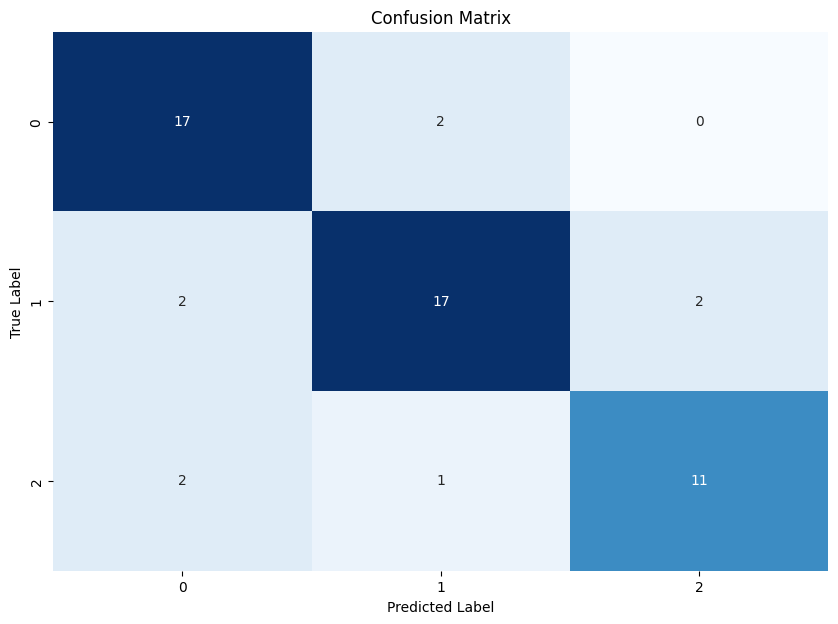

In [83]:
create_report(X_train, y_train, max_depth=3, entropy_function=calculate_entropy)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.91      1.00      0.95        21
           2       1.00      0.93      0.96        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



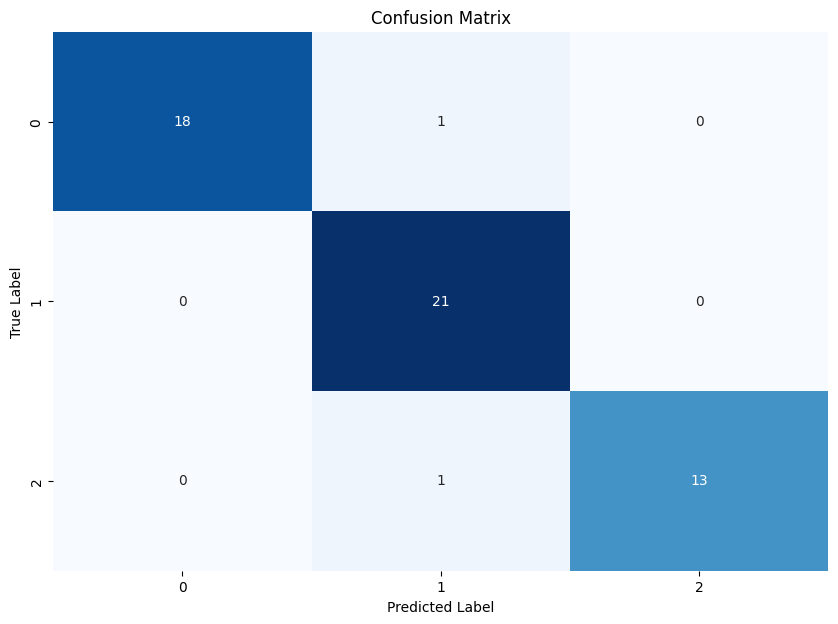

In [84]:
create_report(X_train, y_train, max_depth=3, entropy_function=gini_impurity)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.91      1.00      0.95        21
           2       1.00      0.93      0.96        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



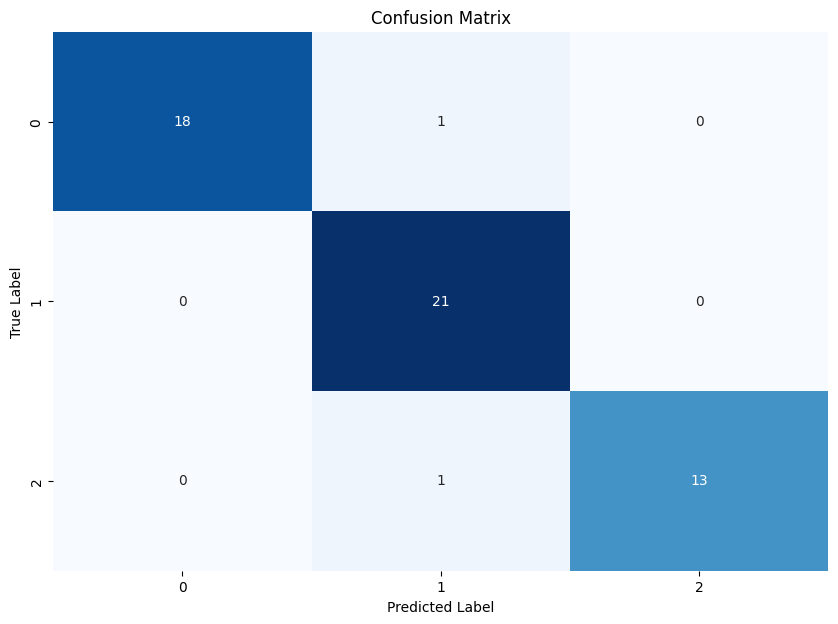

In [91]:
create_report(X_train, y_train, max_depth=3, entropy_function=calculate_tsallis_entropy3)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.91      1.00      0.95        21
           2       1.00      0.93      0.96        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



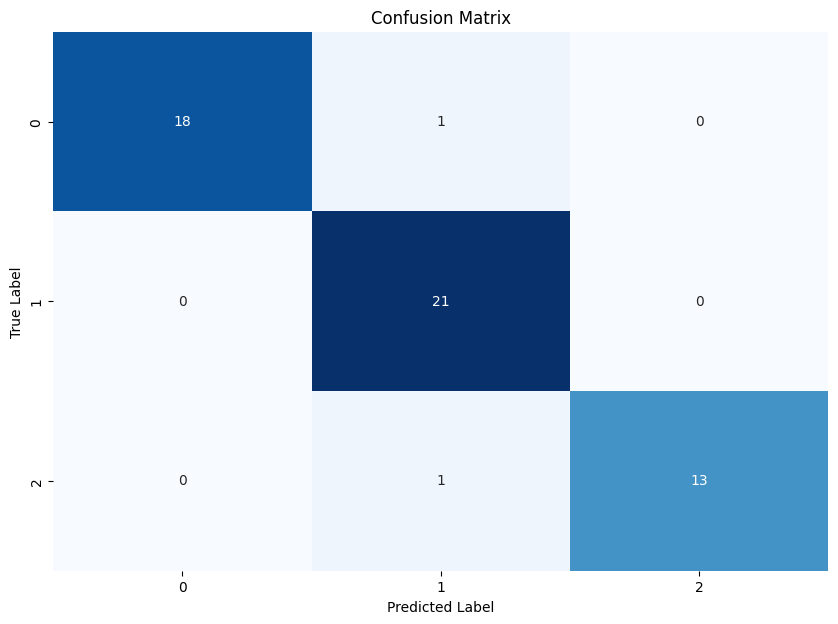

In [92]:
create_report(X_train, y_train, max_depth=3, entropy_function=calculate_tsallis_entropy4)

### iris dataset



In [79]:
X, y = load_wine(return_X_y=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<ipython-input-70-a1d8cb6cd6f1>:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return -np.sum(p*np.log(p) for p in probs)


              precision    recall  f1-score   support

           0       0.81      0.89      0.85        19
           1       0.85      0.81      0.83        21
           2       0.85      0.79      0.81        14

    accuracy                           0.83        54
   macro avg       0.84      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54



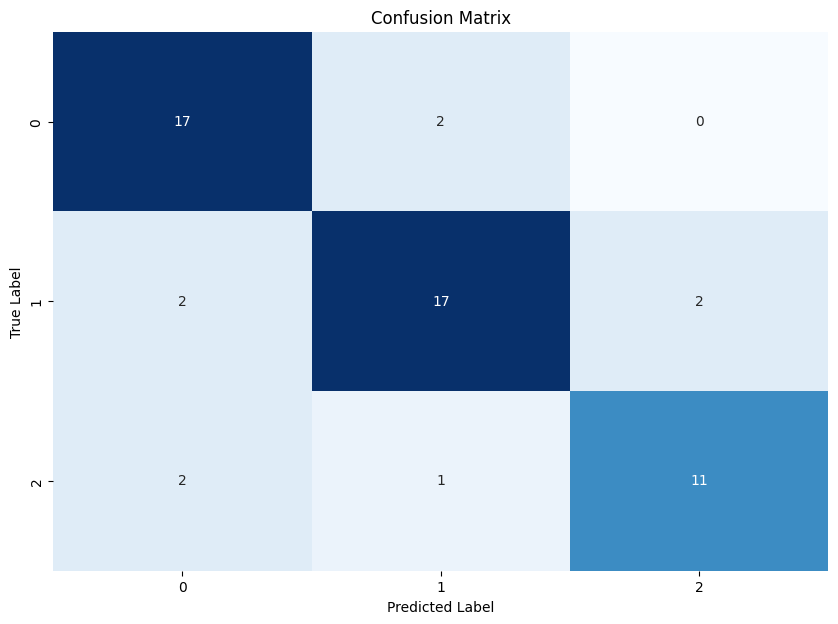

In [80]:
create_report(X_train, y_train, max_depth=3, entropy_function=calculate_entropy)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.91      1.00      0.95        21
           2       1.00      0.93      0.96        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



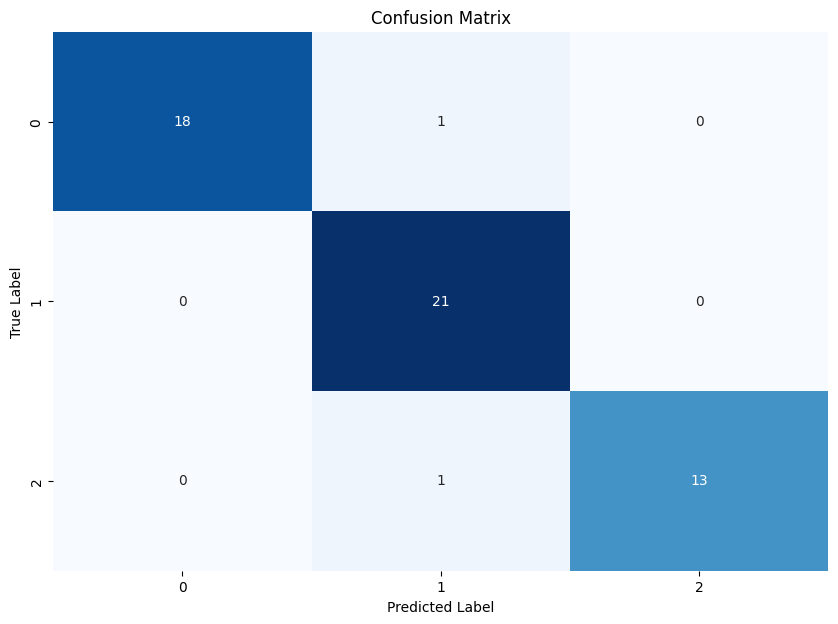

In [81]:
create_report(X_train, y_train, max_depth=3, entropy_function=gini_impurity)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.91      1.00      0.95        21
           2       1.00      0.93      0.96        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



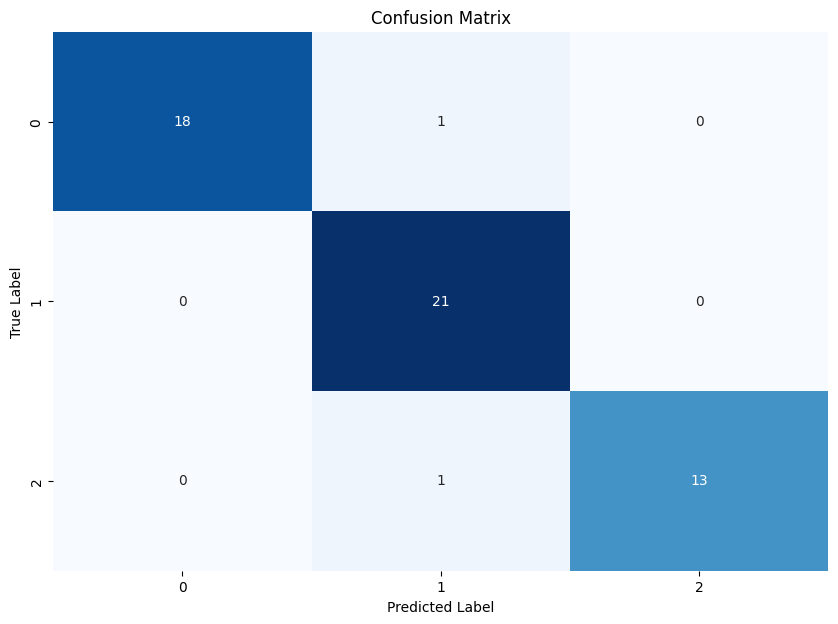

In [89]:
create_report(X_train, y_train, max_depth=3, entropy_function=calculate_tsallis_entropy3)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.91      1.00      0.95        21
           2       1.00      0.93      0.96        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



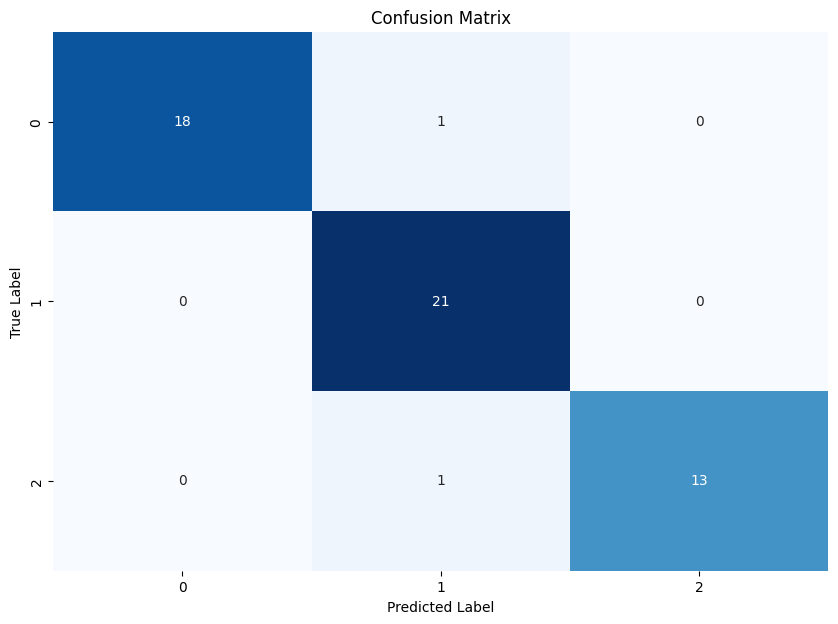

In [88]:
create_report(X_train, y_train, max_depth=3, entropy_function=calculate_tsallis_entropy4)